In [76]:
import sqlite3
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from math import sqrt
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
# Create your connection.
cnx = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [78]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [79]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

# Feature Set

Let's start with dropping few features as those seems insignificant predicting player rating

In [80]:
df = df.drop(labels=['id', 'player_fifa_api_id', 'player_api_id', 'date'
                     ],axis=1)

Replace null values with 0

In [81]:
df.fillna(0, inplace=True)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 38 columns):
overall_rating         183978 non-null float64
potential              183978 non-null float64
preferred_foot         183978 non-null object
attacking_work_rate    183978 non-null object
defensive_work_rate    183978 non-null object
crossing               183978 non-null float64
finishing              183978 non-null float64
heading_accuracy       183978 non-null float64
short_passing          183978 non-null float64
volleys                183978 non-null float64
dribbling              183978 non-null float64
curve                  183978 non-null float64
free_kick_accuracy     183978 non-null float64
long_passing           183978 non-null float64
ball_control           183978 non-null float64
acceleration           183978 non-null float64
sprint_speed           183978 non-null float64
agility                183978 non-null float64
reactions              183978 non-null float64

Here it looks like most of the columns are numeric except 3. 
So convert categorical column into numeric with dummy columns

In [83]:

# pref_foot_dummies = pd.get_dummies(df.preferred_foot, prefix='pref_foot').iloc[:, 1:]


In [84]:
# df = pd.concat([df,pref_foot_dummies], axis=1)
# df.head()

In [85]:
df.columns

Index(['overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 38 columns):
overall_rating         183978 non-null float64
potential              183978 non-null float64
preferred_foot         183978 non-null object
attacking_work_rate    183978 non-null object
defensive_work_rate    183978 non-null object
crossing               183978 non-null float64
finishing              183978 non-null float64
heading_accuracy       183978 non-null float64
short_passing          183978 non-null float64
volleys                183978 non-null float64
dribbling              183978 non-null float64
curve                  183978 non-null float64
free_kick_accuracy     183978 non-null float64
long_passing           183978 non-null float64
ball_control           183978 non-null float64
acceleration           183978 non-null float64
sprint_speed           183978 non-null float64
agility                183978 non-null float64
reactions              183978 non-null float64

Now drop the columns having categorical data

In [87]:
df = df.drop(['preferred_foot','attacking_work_rate','defensive_work_rate'], axis=1)

# Feature Selection

### Feature selection using scikit library

In [88]:
X = df.drop('overall_rating',axis=1).values
Y = df['overall_rating'].values.ravel()
from sklearn.preprocessing import scale
X = scale(X)
df_1 = df.drop('overall_rating',axis=1)

In [90]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=15)
rfe_fit = rfe.fit(X, Y)
features = []
for feat in df_1.columns[rfe_fit.support_]:
    print(feat)
    features.append(feat)

potential
crossing
heading_accuracy
short_passing
ball_control
reactions
strength
aggression
marking
sliding_tackle
gk_diving
gk_handling
gk_kicking
gk_positioning
gk_reflexes


## Analysis of impact of features on the dependent variable using statsmodel

In [91]:
import statsmodels.formula.api as sm
model1 = sm.OLS(df['overall_rating'],df[features])
result1 = model1.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 7.179e+06
Date:                Sat, 27 Oct 2018   Prob (F-statistic):               0.00
Time:                        13:40:41   Log-Likelihood:            -4.5318e+05
No. Observations:              183978   AIC:                         9.064e+05
Df Residuals:                  183963   BIC:                         9.065e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
potential            0.3596      0.001    311.922      0.000       0.357       0.362
crossing             0.0295      0.001     41.488      0.000       0.028       0.031
heading_accuracy     0.0764      0.001    105.497      0.000       0.075       0.078
short_passing        0.0562      0.001     47.883      0.000       0.054       0.059
ball_control         0.1432      0.001    105.540      0.000       0.141       0.146
reactions            0.2205      0.001    209.344      0.000       0.218       0.223
strength             0.0557      0.001     75.831      0.000       0.054       0.057
aggression           0.0248      0.001     37.813      0.000       0.024       0.026
marking              0.0251      0.001     31.650      0.000       0.024       0.027
sliding_tackle      -0.0178      0.001    -24.153      0.000      -0.019      -0.016
gk_diving            0.1681      0.001    116.497      0.000       0.165       0.171
gk_handling          0.0270      0.002     13.896      0.000       0.023       0.031
gk_kicking          -0.0269      0.001    -46.635      0.000      -0.028      -0.026
gk_positioning       0.0476      0.002     24.656      0.000       0.044       0.051
gk_reflexes          0.0204      0.002     10.790      0.000       0.017       0.024
==============================================================================
Omnibus:                     7330.408   Durbin-Watson:                   0.369
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16862.443
Skew:                          -0.244   Prob(JB):                         0.00
Kurtosis:                       4.401   Cond. No.                         67.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Significance of OLS regression results 

1. Adjusted R-Square indicates that 99.8% of the player rating can be explained using predictor variable
2. Regression coefficient (coef) denotes the change in the dependent variable for one unit change in predictor   variable when other variables held constant.
3. The standard error measures the accuracy of potential's coefficient by estimating the variation of the coefficient if the same test were run on a different sample of our population.
4. Our standard error,0.002, is low and therefore appears accurate.
5. A low p-value indicates that the results are statistically significant, that is in general the p-value is less than 0.05.

# Regression Plot

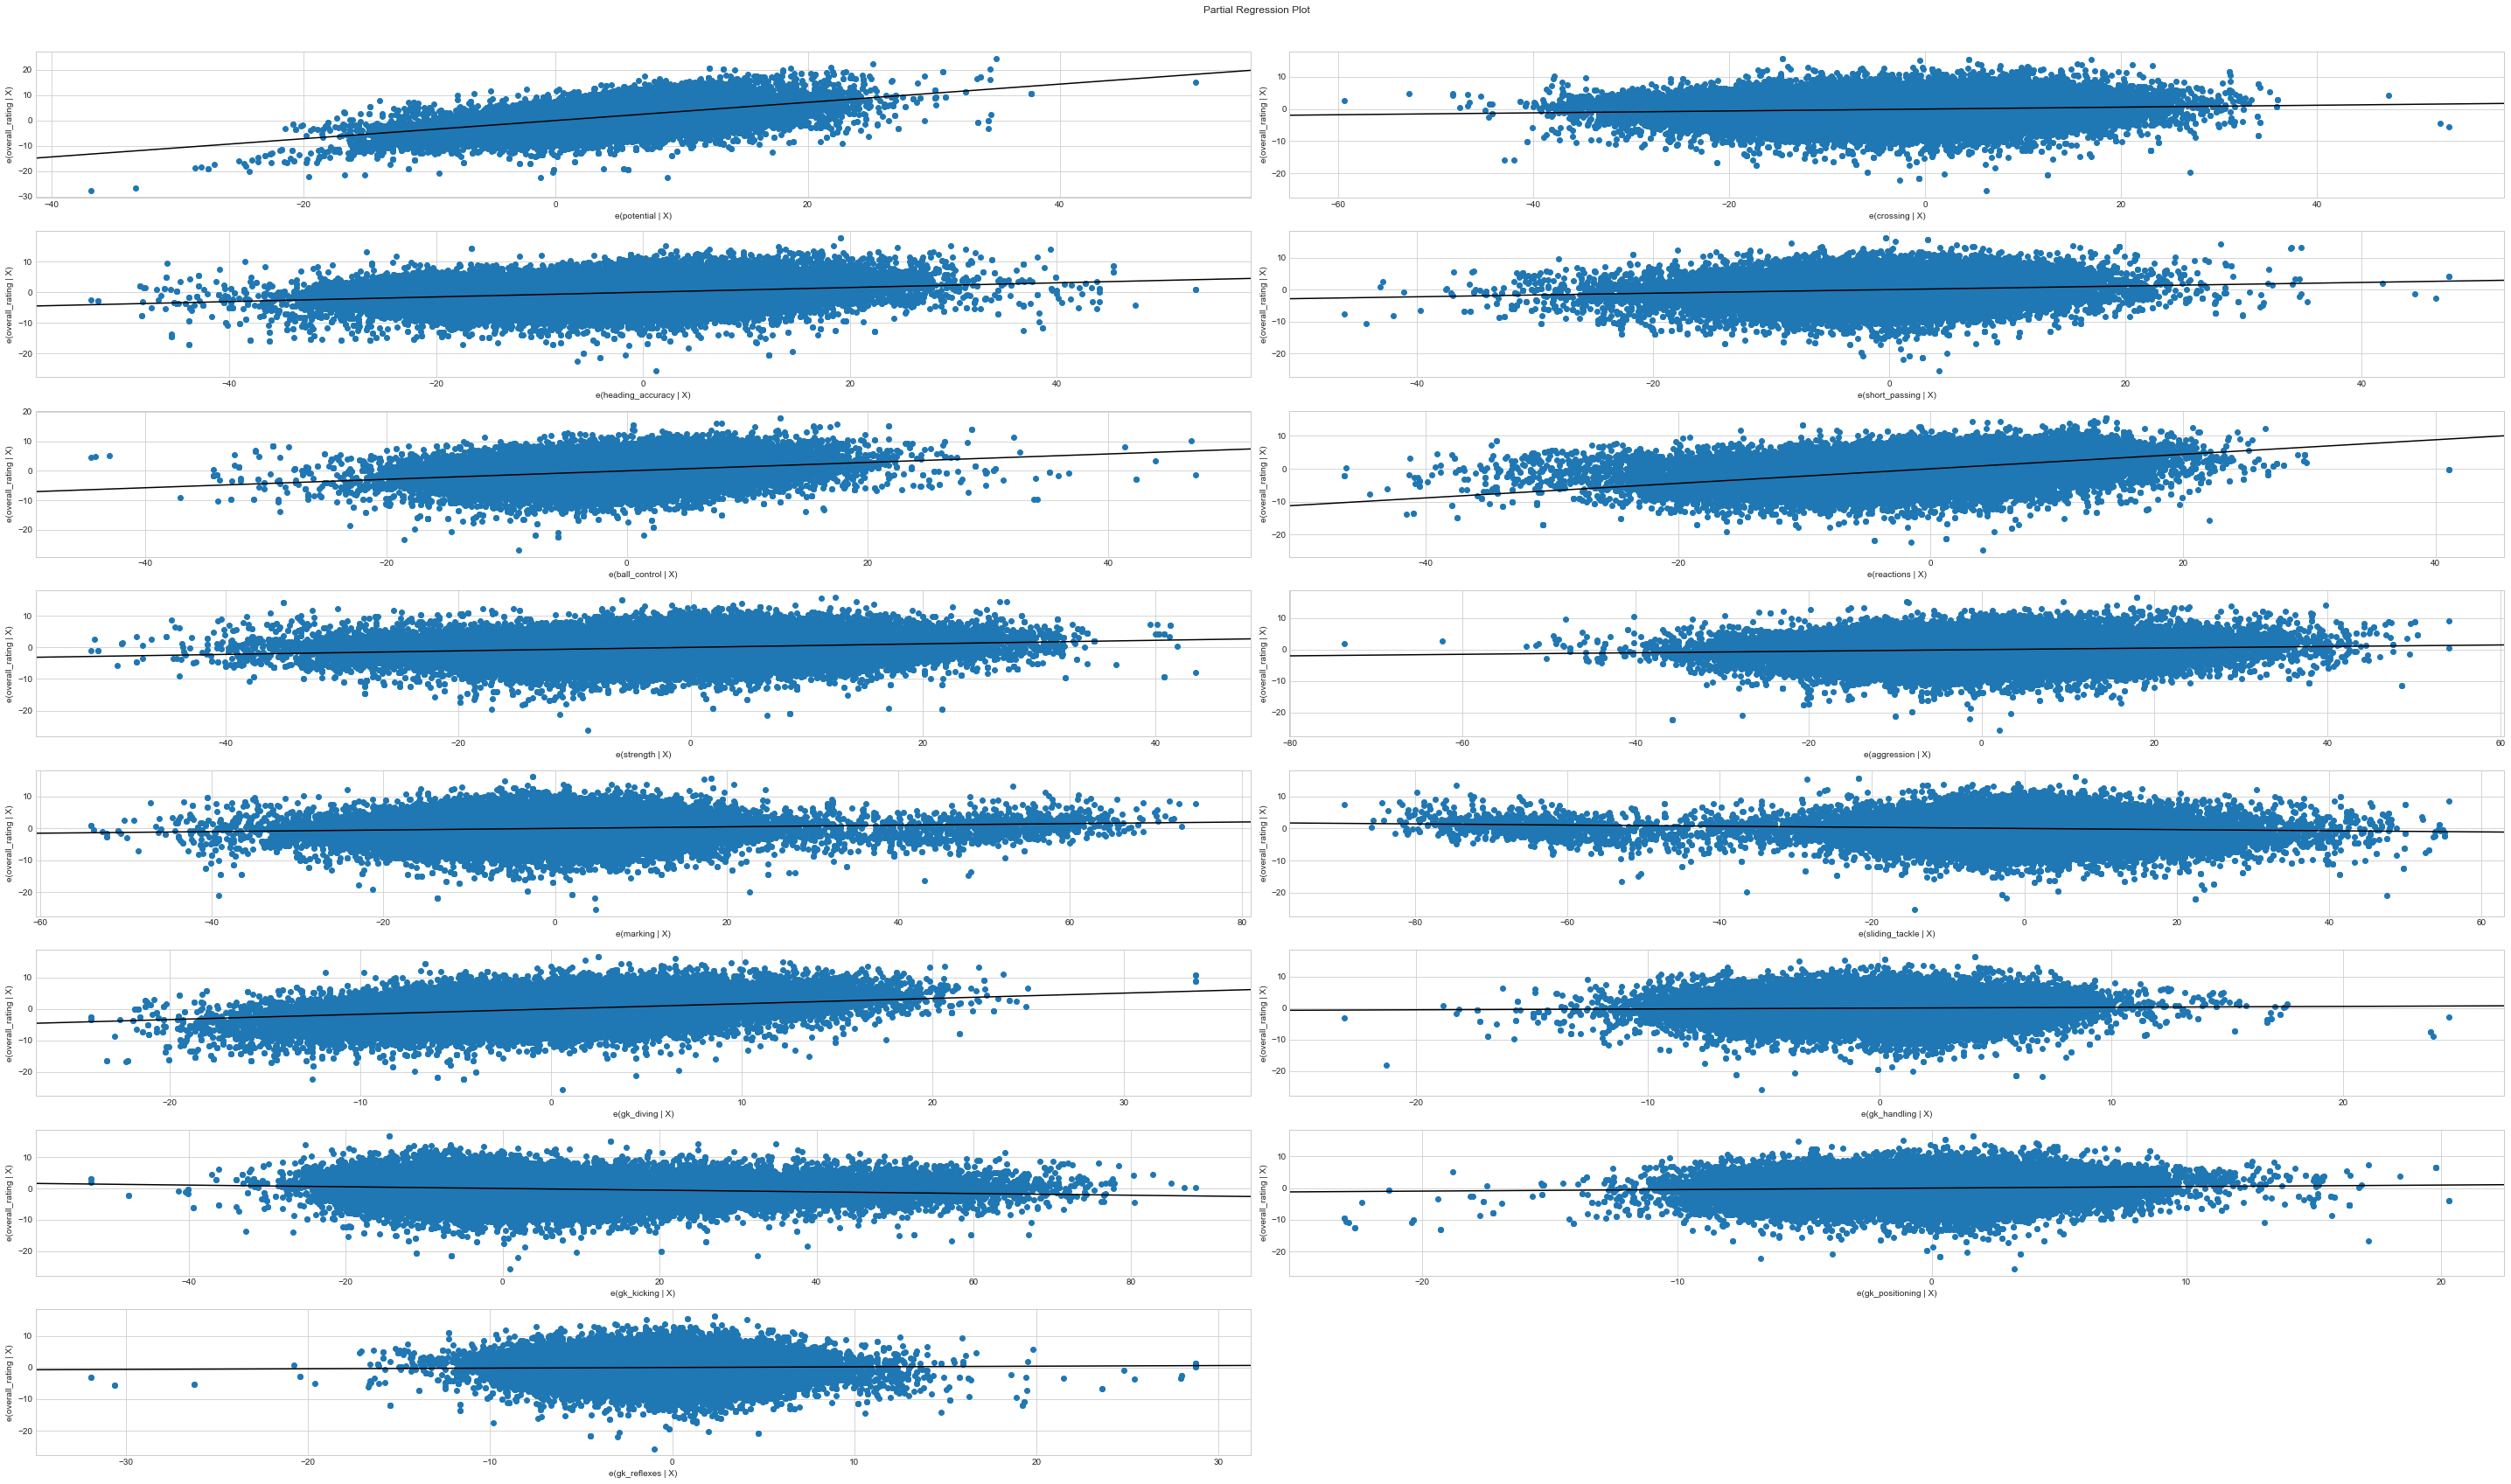

In [92]:
import statsmodels.api as statm
fig = plt.figure(figsize=(40,24))
fig = statm.graphics.plot_partregress_grid(result1, fig=fig)

# Data Visualization

In [93]:
df_corr = df.corr()

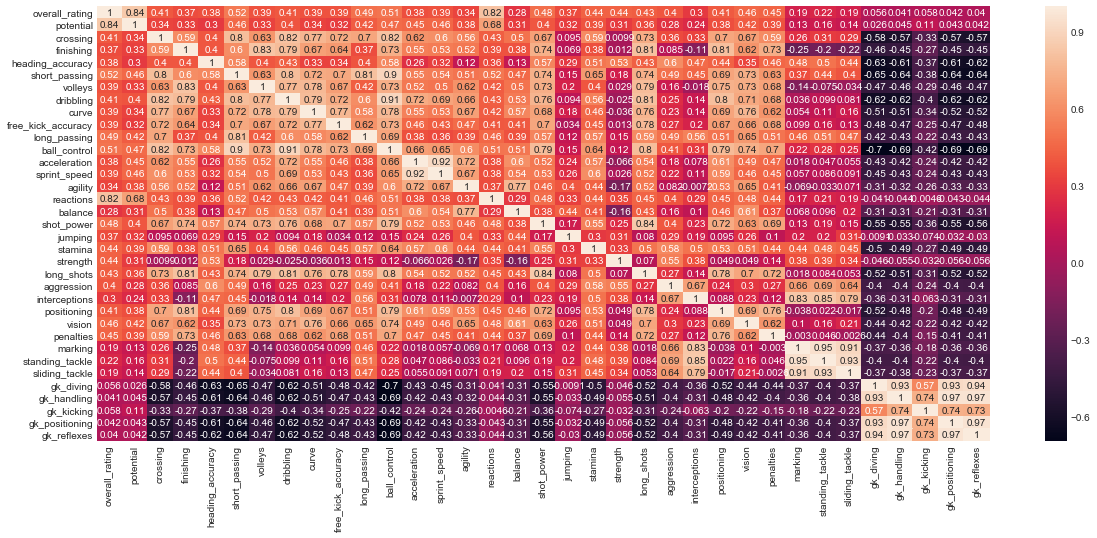

In [94]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(20,8))
sns.heatmap(df_corr,annot=True)

In [126]:
#create correlation matrix with absolute values
df_corr = df.corr().abs()
#select upper triangle of matrix
up_tri = df_corr.where(np.triu(np.ones(df_corr.shape[1]),k=1).astype(np.bool))

#find all the features which have a correlation > 0.85 with other features.
corr_features = [ column for column in up_tri.columns if any(up_tri[column]> 0.85)]

#Print Correlated features
print(corr_features)

['ball_control', 'sprint_speed', 'standing_tackle', 'sliding_tackle', 'gk_handling', 'gk_positioning', 'gk_reflexes']


In [128]:

#Drop Correlated Features
df_no_corr = df.drop(corr_features,axis=1)
df_no_corr.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,gk_diving,gk_kicking
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,6.0,10.0
1,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,6.0,10.0
2,62.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,6.0,10.0
3,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,5.0,9.0
4,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,5.0,9.0


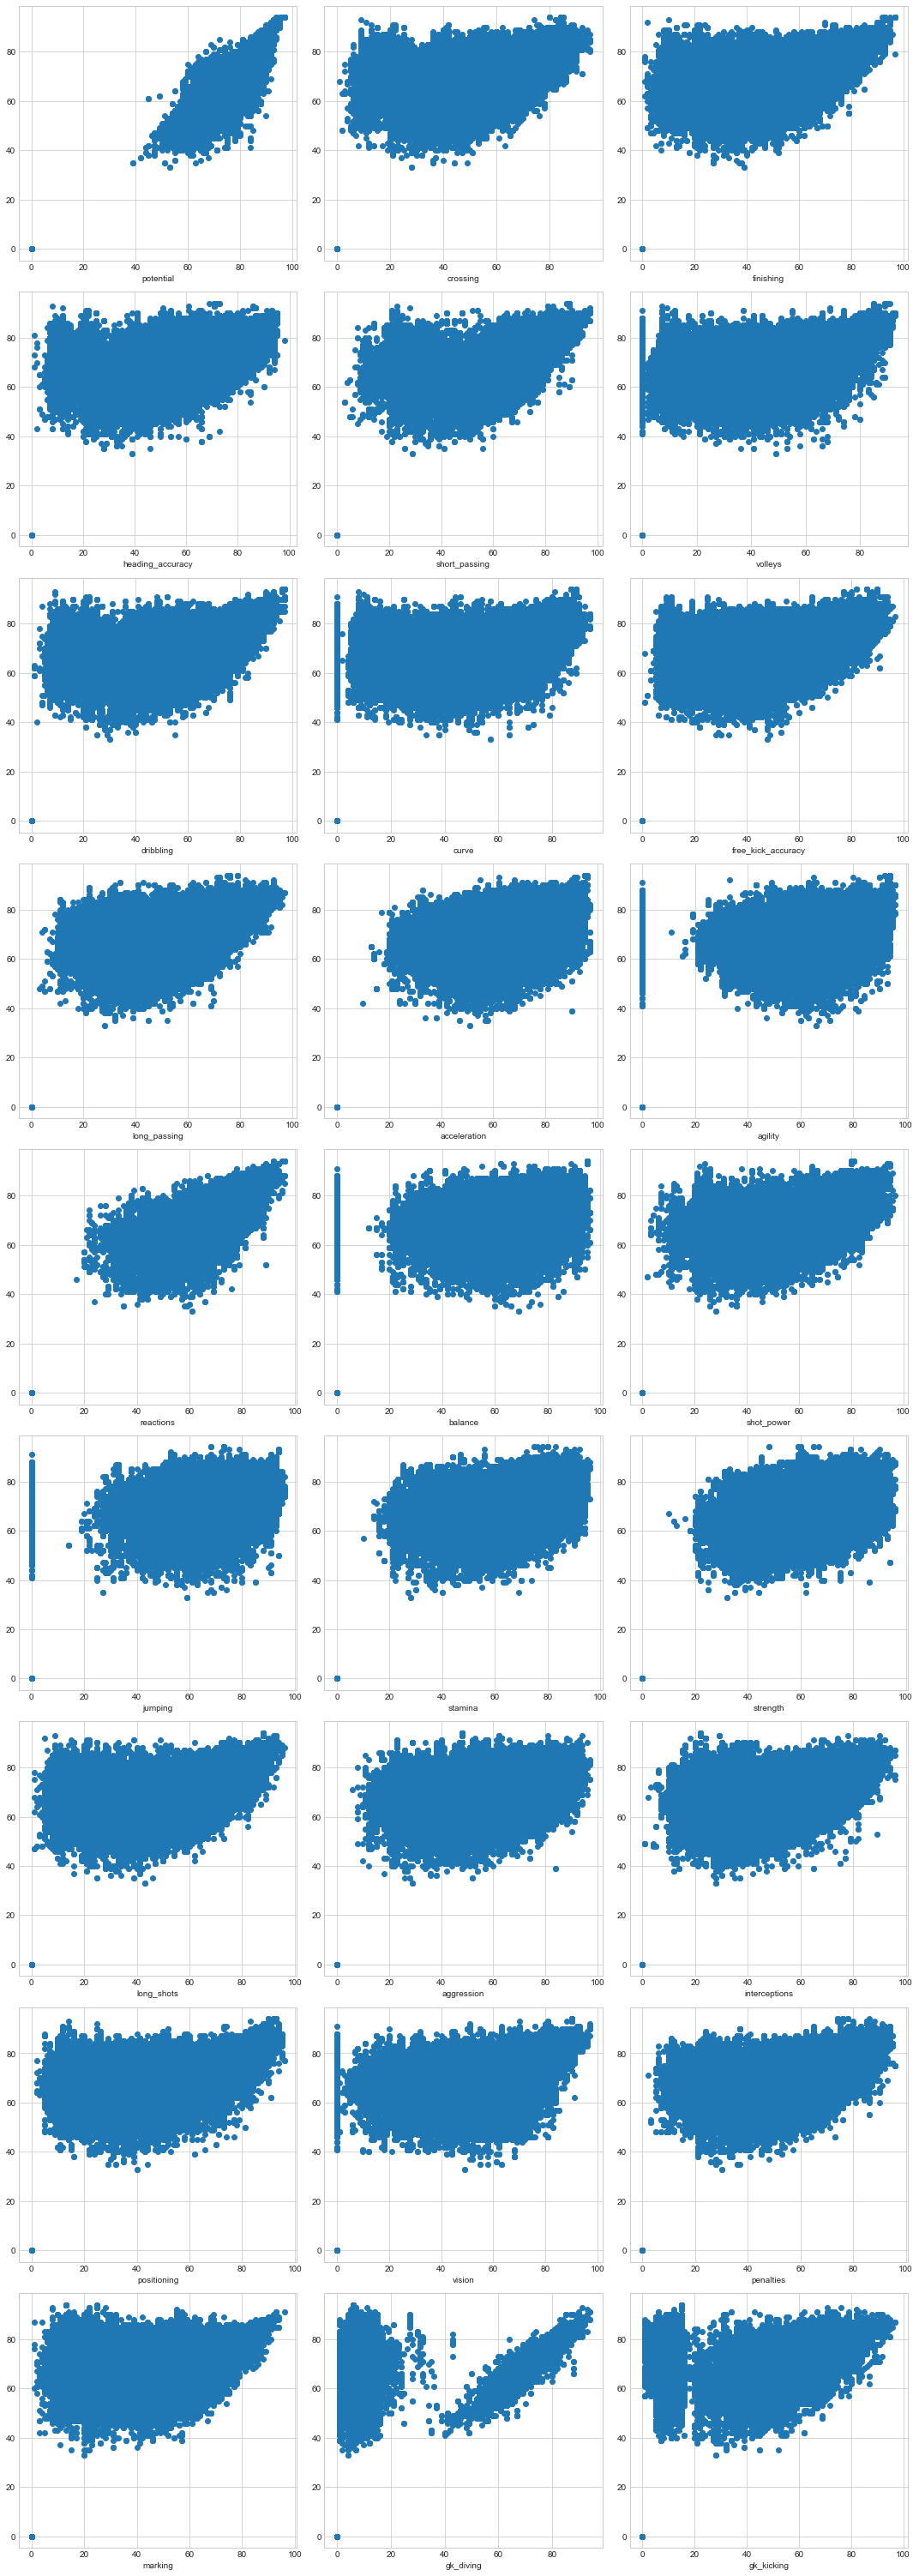

In [109]:
fig = plt.figure(figsize = (15,60))
X = df_no_corr.drop(['overall_rating'],axis=1)
Y = df_no_corr['overall_rating'].values.ravel()
val = X.shape[1]
for idx in range(val):
    feature = X.columns[idx]
    ax = fig.add_subplot(13,3,idx+1)
    Xtmp = X[feature]
    ax.scatter(Xtmp, Y)
    ax.set_xlabel(feature)

plt.tight_layout()
plt.show()

# Model Creation

#### Split the data

In [129]:

X = df_no_corr.drop(['overall_rating'],axis=1)
Y = df_no_corr['overall_rating']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 0)

#### Apply Linear regression model

In [130]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Predict the rating

In [131]:
predicted_overall_rating = regressor.predict(x_test)

In [132]:
predicted_overall_rating

array([70.28945996, 67.20182646, 57.93139866, ..., 56.75006218,
       62.26989541, 62.16184432])

In [133]:
print("The variance score of the LinearRegression model is  : ",regressor.score(x_test,y_test))

The variance score of the LinearRegression model is  :  0.8794544914080153


# Model evaluation

In [134]:
msr = mean_squared_error(y_test, predicted_overall_rating)
rmsr = np.sqrt(msr)
print('Mean Squared Error = ', msr)
print('Root Mean Squared Error = ', rmsr)

Mean Squared Error =  8.355498394105968
Root Mean Squared Error =  2.890587897661299


Text(0.5,1,'Actual vs Predicted Rating for DecisionTreeRegressor Model')

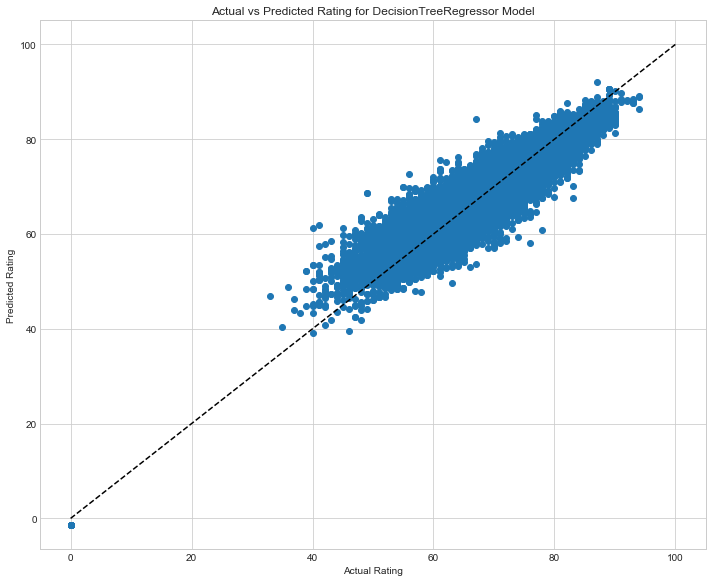

In [135]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, predicted_overall_rating)
plt.plot([0, 100], [0, 100], '--k')
plt.axis('tight')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.tight_layout()
plt.title("Actual vs Predicted Rating for DecisionTreeRegressor Model")

# Applying Decision tree regressor

In [136]:
dTreeRegressor  = DecisionTreeRegressor(max_depth=20)
dTreeRegressor.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

#### Predict overall rating using decision tree 

In [137]:
y_pred = dTreeRegressor.predict(x_test)

In [138]:
y_pred

array([70.        , 66.        , 58.        , ..., 55.        ,
       59.90909091, 57.12903226])

In [140]:
print("The variance score of the DecisionTreeRegressor model is  : ",dTreeRegressor.score(x_test,y_test))

The variance score of the DecisionTreeRegressor model is  :  0.9622936691480215


### Calculate accuracy of decision tree regressor model

In [141]:
print("Error Rate of the DecisionTreeRegressor Model : ",sqrt(mean_squared_error(y_pred,y_test)))

Error Rate of the DecisionTreeRegressor Model :  1.6166566765620538


From the error rate of two model it is evident that decision tree regressor performs better in this case

In [167]:
from sklearn.cross_validation import KFold
kfold = KFold(len(df_no_corr),n_folds=10,shuffle=True,random_state=0)

In [168]:
from sklearn.metrics import mean_absolute_error
lm = LinearRegression()
mean_abs_error = []
accuracy_score = []
for train,test in kfold:
    x = X.iloc[train]
    y = Y.iloc[train]
    lm.fit(x,y)
    Y_test = Y.iloc[test]
    Y_pred = lm.predict(X.iloc[test])
    mean_abs_error.append(mean_absolute_error(Y_test,Y_pred))

In [169]:

print('10 Fold Cross Validation Error : {} accuracy score : {}  for LinearRegression Model '.format(np.mean(mean_abs_error),1 - np.mean(mean_abs_error)))

10 Fold Cross Validation Error : 2.209439515388097 accuracy score : -1.2094395153880968  for LinearRegression Model 


In [171]:

from sklearn.metrics import mean_absolute_error
#DR = LinearRegression()
mean_abs_error = []
accuracy_score = []
for train,test in kfold:
    x = X.iloc[train]
    y = Y.iloc[train]
    regressor.fit(x,y)
    Y_test = Y.iloc[test]
    Y_pred = dTreeRegressor.predict(X.iloc[test])
    mean_abs_error.append(mean_absolute_error(Y_test,Y_pred))

In [172]:
print('10 Fold Cross Validation Error : {} accuracy score : {}  for DecisionTreeRegressor Model '.format(np.mean(mean_abs_error),1 - np.mean(mean_abs_error)))

10 Fold Cross Validation Error : 0.34425646136352744 accuracy score : 0.6557435386364725  for DecisionTreeRegressor Model 
